## Download Data

In [1]:
import os
import opendatasets as od

from pathlib import Path


In [2]:
def download_data(source: str) -> Path:
    """Downloads dataset from kaggle link."""
    data_path = Path(source.split("/")[4] + "/")
    print(data_path)

    # Check if folder exists
    if data_path.is_dir():
        print(f"[INFO] {data_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {data_path} directory, creating one...")
        od.download("https://www.kaggle.com/competitions/dog-breed-identification/data")

    return data_path


In [3]:
data_path = download_data("https://www.kaggle.com/competitions/dog-breed-identification/data")


dog-breed-identification
[INFO] dog-breed-identification directory already exists, skipping download.


## Explore Data

### Look at Top 10 breeds

In [4]:
import pandas as pd


In [5]:
df_breeds = pd.read_csv("dog-breed-identification\labels.csv")
df_breeds


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [6]:
# Count no of images for each breed
df_breeds_count = df_breeds.groupby(["breed"])["id"].count()
df_breeds_count


breed
affenpinscher                      80
afghan_hound                      116
african_hunting_dog                86
airedale                          107
american_staffordshire_terrier     74
                                 ... 
welsh_springer_spaniel             79
west_highland_white_terrier        81
whippet                            95
wire-haired_fox_terrier            82
yorkshire_terrier                  82
Name: id, Length: 120, dtype: int64

In [7]:
# Look at top 10 breeds with most images
df_breeds_count_top = df_breeds_count.sort_values(ascending=False)
df_breeds_count_top[:10]


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: id, dtype: int64

### View some images of the top 10 breeds

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


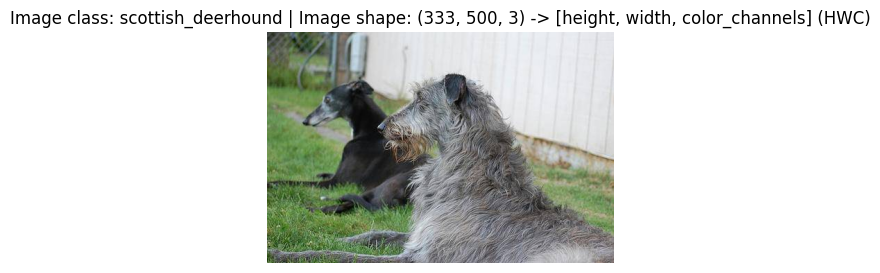

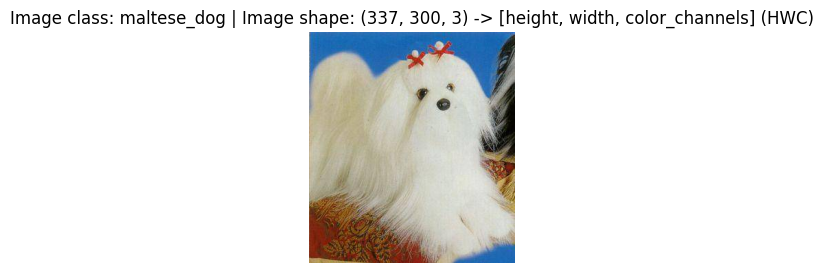

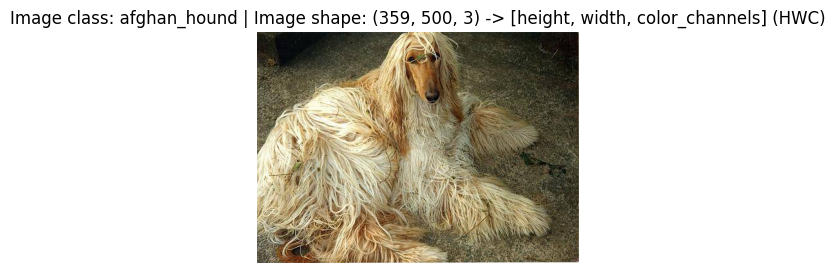

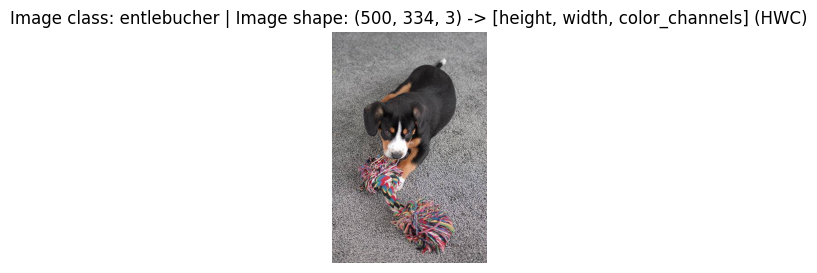

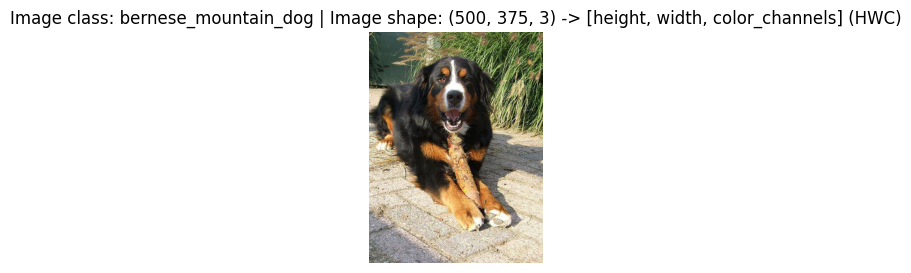

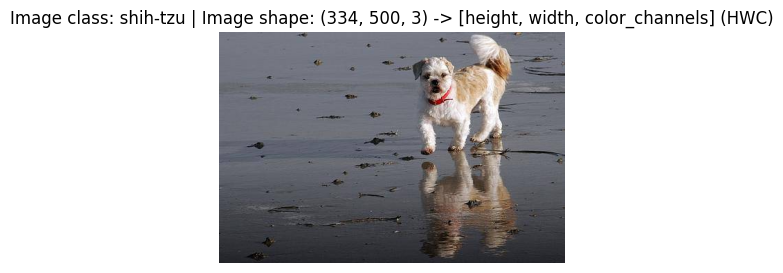

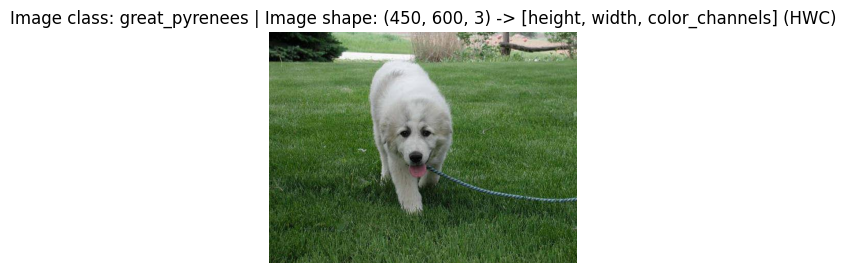

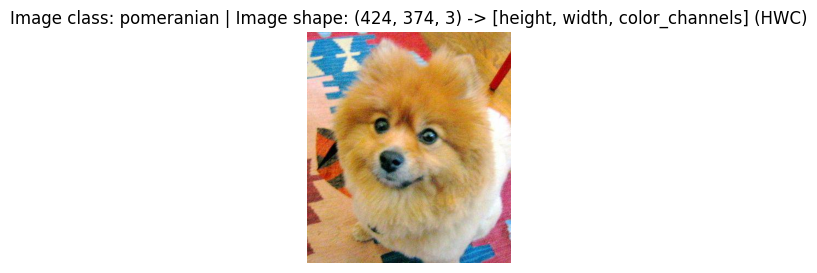

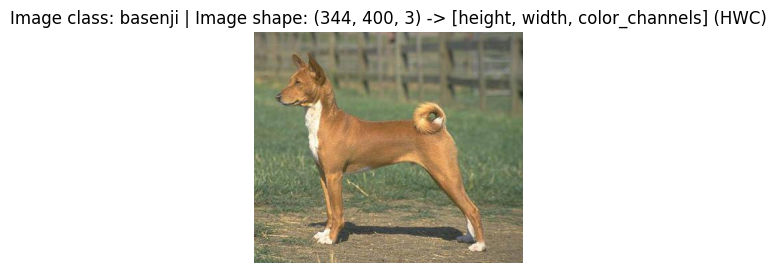

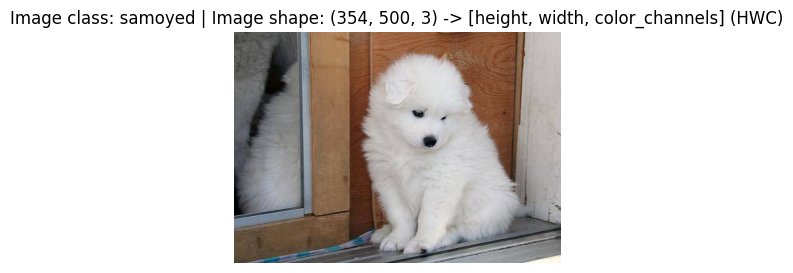

In [9]:
# Plot one image for each breed in the top 10 from train set
for breed in df_breeds_count_top[:10].index:
    # Get list of images for that breed
    df_selected_breed = df_breeds[df_breeds["breed"] == breed]
    image_list = df_selected_breed["id"].tolist()

    # Select random image
    random_image = random.choice(image_list)

    # Create image path
    image_path = "dog-breed-identification/train/" + random_image + ".jpg"
    image = Image.open(image_path)

    image_as_array = np.asarray(image)

    # Want 2 columns, 5 rows of images

    # Plot the image with matplotlib
    plt.figure(figsize=(5, 3))
    plt.imshow(image_as_array)
    plt.title(
        f"Image class: {breed} | Image shape: {image_as_array.shape} -> [height, width, color_channels] (HWC)"
    )
    plt.axis(False)


Noticed that there are some images where the dog covers only a small part of the image. May need bounding boxes to determine where exactly the dog is.

### Set up dataloaders

As data downloaded is not in the format needed for `datasets.ImageFolder`, we will need to write some code to create a new folder which is in the format required. We will also need to split the train data into train and test data.

In [10]:
import shutil

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split


c:\Projects\dog-breed-classification\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
X = df_breeds["id"]
y = df_breeds["breed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [12]:
df_train = pd.concat([X_train, y_train], axis=1).reset_index()
df_test = pd.concat([X_test, y_test], axis=1).reset_index()


In [13]:
# Create folder for data in the required format

for type in ["train", "test"]:
    # Create train and test folders

    folder_directory = data_path / "formatted" / type

    if type == "train":
        df = df_train
    elif type == "test":
        df = df_test
    else:
        print("ERROR")

    # Check if folder exists
    if folder_directory.is_dir():
        print(f"[INFO] {folder_directory} directory already exists.")
    else:
        print(f"[INFO] Did not find {folder_directory} directory, creating one...")
        os.makedirs(folder_directory)

    for breed in tqdm(df_breeds_count.index):
        breed_folder_path = folder_directory / breed
        if breed_folder_path.is_dir():
            print(f"[INFO] {breed_folder_path} directory already exists.")
        else:
            print(f"[INFO] Did not find {breed_folder_path} directory, creating one...")
            os.mkdir(breed_folder_path)

            df_selected_breed = df[df["breed"] == breed]
            image_list = df_selected_breed["id"].tolist()

            for image in image_list:
                image_name = image + ".jpg"
                source_image_path = data_path / "train" / image_name
                destination_image_path = data_path / "formatted" / type / breed / image_name

                # Check if file exists in source
                shutil.copy(source_image_path, destination_image_path)


[INFO] Did not find dog-breed-identification\formatted\train directory, creating one...


  0%|          | 0/120 [00:00<?, ?it/s]

[INFO] Did not find dog-breed-identification\formatted\train\affenpinscher directory, creating one...


  1%|          | 1/120 [00:00<00:19,  5.97it/s]

[INFO] Did not find dog-breed-identification\formatted\train\afghan_hound directory, creating one...


  2%|▏         | 2/120 [00:00<00:31,  3.78it/s]

[INFO] Did not find dog-breed-identification\formatted\train\african_hunting_dog directory, creating one...


  2%|▎         | 3/120 [00:00<00:30,  3.89it/s]

[INFO] Did not find dog-breed-identification\formatted\train\airedale directory, creating one...


  3%|▎         | 4/120 [00:01<00:32,  3.53it/s]

[INFO] Did not find dog-breed-identification\formatted\train\american_staffordshire_terrier directory, creating one...


  4%|▍         | 5/120 [00:01<00:30,  3.75it/s]

[INFO] Did not find dog-breed-identification\formatted\train\appenzeller directory, creating one...


  5%|▌         | 6/120 [00:01<00:30,  3.74it/s]

[INFO] Did not find dog-breed-identification\formatted\train\australian_terrier directory, creating one...


  6%|▌         | 7/120 [00:01<00:30,  3.69it/s]

[INFO] Did not find dog-breed-identification\formatted\train\basenji directory, creating one...


  8%|▊         | 9/120 [00:02<00:27,  3.98it/s]

[INFO] Did not find dog-breed-identification\formatted\train\basset directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\beagle directory, creating one...


  8%|▊         | 10/120 [00:02<00:27,  3.98it/s]

[INFO] Did not find dog-breed-identification\formatted\train\bedlington_terrier directory, creating one...


  9%|▉         | 11/120 [00:02<00:26,  4.15it/s]

[INFO] Did not find dog-breed-identification\formatted\train\bernese_mountain_dog directory, creating one...


 10%|█         | 12/120 [00:03<00:28,  3.74it/s]

[INFO] Did not find dog-breed-identification\formatted\train\black-and-tan_coonhound directory, creating one...


 11%|█         | 13/120 [00:03<00:27,  3.95it/s]

[INFO] Did not find dog-breed-identification\formatted\train\blenheim_spaniel directory, creating one...


 12%|█▏        | 14/120 [00:03<00:27,  3.82it/s]

[INFO] Did not find dog-breed-identification\formatted\train\bloodhound directory, creating one...


 12%|█▎        | 15/120 [00:03<00:28,  3.63it/s]

[INFO] Did not find dog-breed-identification\formatted\train\bluetick directory, creating one...


 14%|█▍        | 17/120 [00:04<00:24,  4.29it/s]

[INFO] Did not find dog-breed-identification\formatted\train\border_collie directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\border_terrier directory, creating one...


 16%|█▌        | 19/120 [00:04<00:21,  4.79it/s]

[INFO] Did not find dog-breed-identification\formatted\train\borzoi directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\boston_bull directory, creating one...


 18%|█▊        | 21/120 [00:05<00:21,  4.60it/s]

[INFO] Did not find dog-breed-identification\formatted\train\bouvier_des_flandres directory, creating one...


 18%|█▊        | 22/120 [00:05<00:20,  4.71it/s]

[INFO] Did not find dog-breed-identification\formatted\train\boxer directory, creating one...


 19%|█▉        | 23/120 [00:05<00:19,  5.05it/s]

[INFO] Did not find dog-breed-identification\formatted\train\brabancon_griffon directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\briard directory, creating one...


 21%|██        | 25/120 [00:05<00:17,  5.54it/s]

[INFO] Did not find dog-breed-identification\formatted\train\brittany_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\bull_mastiff directory, creating one...


 22%|██▏       | 26/120 [00:06<00:15,  5.92it/s]

[INFO] Did not find dog-breed-identification\formatted\train\cairn directory, creating one...


 23%|██▎       | 28/120 [00:06<00:16,  5.49it/s]

[INFO] Did not find dog-breed-identification\formatted\train\cardigan directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\chesapeake_bay_retriever directory, creating one...


 25%|██▌       | 30/120 [00:06<00:16,  5.52it/s]

[INFO] Did not find dog-breed-identification\formatted\train\chihuahua directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\chow directory, creating one...


 27%|██▋       | 32/120 [00:07<00:14,  5.97it/s]

[INFO] Did not find dog-breed-identification\formatted\train\clumber directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\cocker_spaniel directory, creating one...


 28%|██▊       | 33/120 [00:07<00:15,  5.70it/s]

[INFO] Did not find dog-breed-identification\formatted\train\collie directory, creating one...


 29%|██▉       | 35/120 [00:07<00:16,  5.20it/s]

[INFO] Did not find dog-breed-identification\formatted\train\curly-coated_retriever directory, creating one...


 30%|███       | 36/120 [00:07<00:15,  5.29it/s]

[INFO] Did not find dog-breed-identification\formatted\train\dandie_dinmont directory, creating one...


 31%|███       | 37/120 [00:08<00:14,  5.62it/s]

[INFO] Did not find dog-breed-identification\formatted\train\dhole directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\dingo directory, creating one...


 32%|███▎      | 39/120 [00:08<00:14,  5.40it/s]

[INFO] Did not find dog-breed-identification\formatted\train\doberman directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\english_foxhound directory, creating one...


 34%|███▍      | 41/120 [00:08<00:14,  5.30it/s]

[INFO] Did not find dog-breed-identification\formatted\train\english_setter directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\english_springer directory, creating one...


 35%|███▌      | 42/120 [00:09<00:16,  4.62it/s]

[INFO] Did not find dog-breed-identification\formatted\train\entlebucher directory, creating one...


 37%|███▋      | 44/120 [00:09<00:18,  4.22it/s]

[INFO] Did not find dog-breed-identification\formatted\train\eskimo_dog directory, creating one...


 38%|███▊      | 45/120 [00:09<00:15,  4.75it/s]

[INFO] Did not find dog-breed-identification\formatted\train\flat-coated_retriever directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\french_bulldog directory, creating one...


 39%|███▉      | 47/120 [00:10<00:12,  5.67it/s]

[INFO] Did not find dog-breed-identification\formatted\train\german_shepherd directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\german_short-haired_pointer directory, creating one...


 41%|████      | 49/120 [00:10<00:11,  6.23it/s]

[INFO] Did not find dog-breed-identification\formatted\train\giant_schnauzer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\golden_retriever directory, creating one...


 42%|████▎     | 51/120 [00:10<00:12,  5.74it/s]

[INFO] Did not find dog-breed-identification\formatted\train\gordon_setter directory, creating one...


 43%|████▎     | 52/120 [00:10<00:11,  5.82it/s]

[INFO] Did not find dog-breed-identification\formatted\train\great_dane directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\great_pyrenees directory, creating one...


 45%|████▌     | 54/120 [00:11<00:13,  5.05it/s]

[INFO] Did not find dog-breed-identification\formatted\train\greater_swiss_mountain_dog directory, creating one...


 46%|████▌     | 55/120 [00:11<00:12,  5.03it/s]

[INFO] Did not find dog-breed-identification\formatted\train\groenendael directory, creating one...


 47%|████▋     | 56/120 [00:11<00:12,  5.08it/s]

[INFO] Did not find dog-breed-identification\formatted\train\ibizan_hound directory, creating one...


 48%|████▊     | 57/120 [00:11<00:11,  5.31it/s]

[INFO] Did not find dog-breed-identification\formatted\train\irish_setter directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\irish_terrier directory, creating one...


 48%|████▊     | 58/120 [00:12<00:11,  5.60it/s]

[INFO] Did not find dog-breed-identification\formatted\train\irish_water_spaniel directory, creating one...


 49%|████▉     | 59/120 [00:12<00:13,  4.48it/s]

[INFO] Did not find dog-breed-identification\formatted\train\irish_wolfhound directory, creating one...


 50%|█████     | 60/120 [00:12<00:14,  4.01it/s]

[INFO] Did not find dog-breed-identification\formatted\train\italian_greyhound directory, creating one...


 51%|█████     | 61/120 [00:12<00:13,  4.25it/s]

[INFO] Did not find dog-breed-identification\formatted\train\japanese_spaniel directory, creating one...


 52%|█████▎    | 63/120 [00:13<00:12,  4.62it/s]

[INFO] Did not find dog-breed-identification\formatted\train\keeshond directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\kelpie directory, creating one...


 53%|█████▎    | 64/120 [00:13<00:11,  4.75it/s]

[INFO] Did not find dog-breed-identification\formatted\train\kerry_blue_terrier directory, creating one...


 55%|█████▌    | 66/120 [00:13<00:11,  4.83it/s]

[INFO] Did not find dog-breed-identification\formatted\train\komondor directory, creating one...


 56%|█████▌    | 67/120 [00:14<00:09,  5.34it/s]

[INFO] Did not find dog-breed-identification\formatted\train\kuvasz directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\labrador_retriever directory, creating one...


 57%|█████▋    | 68/120 [00:14<00:10,  5.07it/s]

[INFO] Did not find dog-breed-identification\formatted\train\lakeland_terrier directory, creating one...


 57%|█████▊    | 69/120 [00:14<00:10,  4.69it/s]

[INFO] Did not find dog-breed-identification\formatted\train\leonberg directory, creating one...


 58%|█████▊    | 70/120 [00:14<00:11,  4.47it/s]

[INFO] Did not find dog-breed-identification\formatted\train\lhasa directory, creating one...


 60%|██████    | 72/120 [00:15<00:09,  4.82it/s]

[INFO] Did not find dog-breed-identification\formatted\train\malamute directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\malinois directory, creating one...


 61%|██████    | 73/120 [00:15<00:09,  5.10it/s]

[INFO] Did not find dog-breed-identification\formatted\train\maltese_dog directory, creating one...


 62%|██████▏   | 74/120 [00:15<00:09,  4.77it/s]

[INFO] Did not find dog-breed-identification\formatted\train\mexican_hairless directory, creating one...


 62%|██████▎   | 75/120 [00:15<00:09,  4.73it/s]

[INFO] Did not find dog-breed-identification\formatted\train\miniature_pinscher directory, creating one...


 64%|██████▍   | 77/120 [00:16<00:08,  4.98it/s]

[INFO] Did not find dog-breed-identification\formatted\train\miniature_poodle directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\miniature_schnauzer directory, creating one...


 66%|██████▌   | 79/120 [00:16<00:08,  5.07it/s]

[INFO] Did not find dog-breed-identification\formatted\train\newfoundland directory, creating one...


 67%|██████▋   | 80/120 [00:16<00:07,  5.19it/s]

[INFO] Did not find dog-breed-identification\formatted\train\norfolk_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\norwegian_elkhound directory, creating one...


 68%|██████▊   | 81/120 [00:17<00:07,  4.96it/s]

[INFO] Did not find dog-breed-identification\formatted\train\norwich_terrier directory, creating one...


 69%|██████▉   | 83/120 [00:17<00:08,  4.51it/s]

[INFO] Did not find dog-breed-identification\formatted\train\old_english_sheepdog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\otterhound directory, creating one...


 70%|███████   | 84/120 [00:17<00:08,  4.39it/s]

[INFO] Did not find dog-breed-identification\formatted\train\papillon directory, creating one...


 72%|███████▏  | 86/120 [00:18<00:07,  4.60it/s]

[INFO] Did not find dog-breed-identification\formatted\train\pekinese directory, creating one...


 72%|███████▎  | 87/120 [00:18<00:06,  4.78it/s]

[INFO] Did not find dog-breed-identification\formatted\train\pembroke directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\pomeranian directory, creating one...


 73%|███████▎  | 88/120 [00:18<00:07,  4.40it/s]

[INFO] Did not find dog-breed-identification\formatted\train\pug directory, creating one...


 75%|███████▌  | 90/120 [00:19<00:06,  4.44it/s]

[INFO] Did not find dog-breed-identification\formatted\train\redbone directory, creating one...


 76%|███████▌  | 91/120 [00:19<00:06,  4.58it/s]

[INFO] Did not find dog-breed-identification\formatted\train\rhodesian_ridgeback directory, creating one...


 77%|███████▋  | 92/120 [00:19<00:05,  4.76it/s]

[INFO] Did not find dog-breed-identification\formatted\train\rottweiler directory, creating one...


 78%|███████▊  | 93/120 [00:19<00:05,  5.05it/s]

[INFO] Did not find dog-breed-identification\formatted\train\saint_bernard directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\saluki directory, creating one...


 78%|███████▊  | 94/120 [00:19<00:05,  4.98it/s]

[INFO] Did not find dog-breed-identification\formatted\train\samoyed directory, creating one...


 79%|███████▉  | 95/120 [00:20<00:05,  4.67it/s]

[INFO] Did not find dog-breed-identification\formatted\train\schipperke directory, creating one...


 80%|████████  | 96/120 [00:20<00:05,  4.38it/s]

[INFO] Did not find dog-breed-identification\formatted\train\scotch_terrier directory, creating one...


 81%|████████  | 97/120 [00:20<00:05,  4.30it/s]

[INFO] Did not find dog-breed-identification\formatted\train\scottish_deerhound directory, creating one...


 82%|████████▎ | 99/120 [00:21<00:05,  4.03it/s]

[INFO] Did not find dog-breed-identification\formatted\train\sealyham_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\shetland_sheepdog directory, creating one...


 83%|████████▎ | 100/120 [00:21<00:06,  3.07it/s]

[INFO] Did not find dog-breed-identification\formatted\train\shih-tzu directory, creating one...


 84%|████████▍ | 101/120 [00:21<00:05,  3.21it/s]

[INFO] Did not find dog-breed-identification\formatted\train\siberian_husky directory, creating one...


 85%|████████▌ | 102/120 [00:22<00:06,  2.73it/s]

[INFO] Did not find dog-breed-identification\formatted\train\silky_terrier directory, creating one...


 86%|████████▌ | 103/120 [00:23<00:07,  2.18it/s]

[INFO] Did not find dog-breed-identification\formatted\train\soft-coated_wheaten_terrier directory, creating one...


 87%|████████▋ | 104/120 [00:23<00:06,  2.43it/s]

[INFO] Did not find dog-breed-identification\formatted\train\staffordshire_bullterrier directory, creating one...


 88%|████████▊ | 106/120 [00:23<00:04,  3.13it/s]

[INFO] Did not find dog-breed-identification\formatted\train\standard_poodle directory, creating one...


 89%|████████▉ | 107/120 [00:24<00:03,  3.68it/s]

[INFO] Did not find dog-breed-identification\formatted\train\standard_schnauzer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\sussex_spaniel directory, creating one...


 91%|█████████ | 109/120 [00:24<00:02,  4.48it/s]

[INFO] Did not find dog-breed-identification\formatted\train\tibetan_mastiff directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\tibetan_terrier directory, creating one...


 92%|█████████▎| 111/120 [00:24<00:02,  4.15it/s]

[INFO] Did not find dog-breed-identification\formatted\train\toy_poodle directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\toy_terrier directory, creating one...


 93%|█████████▎| 112/120 [00:25<00:01,  4.24it/s]

[INFO] Did not find dog-breed-identification\formatted\train\vizsla directory, creating one...


 95%|█████████▌| 114/120 [00:25<00:01,  3.95it/s]

[INFO] Did not find dog-breed-identification\formatted\train\walker_hound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\weimaraner directory, creating one...


 97%|█████████▋| 116/120 [00:26<00:00,  4.31it/s]

[INFO] Did not find dog-breed-identification\formatted\train\welsh_springer_spaniel directory, creating one...


 98%|█████████▊| 117/120 [00:26<00:00,  4.52it/s]

[INFO] Did not find dog-breed-identification\formatted\train\west_highland_white_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\train\whippet directory, creating one...


 98%|█████████▊| 118/120 [00:26<00:00,  4.54it/s]

[INFO] Did not find dog-breed-identification\formatted\train\wire-haired_fox_terrier directory, creating one...


100%|██████████| 120/120 [00:27<00:00,  4.65it/s]

[INFO] Did not find dog-breed-identification\formatted\train\yorkshire_terrier directory, creating one...


100%|██████████| 120/120 [00:27<00:00,  4.44it/s]


[INFO] Did not find dog-breed-identification\formatted\test directory, creating one...


  2%|▏         | 2/120 [00:00<00:09, 12.99it/s]

[INFO] Did not find dog-breed-identification\formatted\test\affenpinscher directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\afghan_hound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\african_hunting_dog directory, creating one...


  3%|▎         | 4/120 [00:00<00:08, 14.12it/s]

[INFO] Did not find dog-breed-identification\formatted\test\airedale directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\american_staffordshire_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\appenzeller directory, creating one...


  5%|▌         | 6/120 [00:00<00:07, 14.62it/s]

[INFO] Did not find dog-breed-identification\formatted\test\australian_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\basenji directory, creating one...


  8%|▊         | 10/120 [00:00<00:10, 10.20it/s]

[INFO] Did not find dog-breed-identification\formatted\test\basset directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\beagle directory, creating one...


 10%|█         | 12/120 [00:01<00:10, 10.80it/s]

[INFO] Did not find dog-breed-identification\formatted\test\bedlington_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\bernese_mountain_dog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\black-and-tan_coonhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\blenheim_spaniel directory, creating one...


 14%|█▍        | 17/120 [00:01<00:06, 15.60it/s]

[INFO] Did not find dog-breed-identification\formatted\test\bloodhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\bluetick directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\border_collie directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\border_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\borzoi directory, creating one...


 17%|█▋        | 20/120 [00:01<00:05, 17.31it/s]

[INFO] Did not find dog-breed-identification\formatted\test\boston_bull directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\bouvier_des_flandres directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\boxer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\brabancon_griffon directory, creating one...


 21%|██        | 25/120 [00:01<00:05, 17.96it/s]

[INFO] Did not find dog-breed-identification\formatted\test\briard directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\brittany_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\bull_mastiff directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\cairn directory, creating one...


 25%|██▌       | 30/120 [00:01<00:04, 19.13it/s]

[INFO] Did not find dog-breed-identification\formatted\test\cardigan directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\chesapeake_bay_retriever directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\chihuahua directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\chow directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\clumber directory, creating one...


 28%|██▊       | 33/120 [00:02<00:04, 20.13it/s]

[INFO] Did not find dog-breed-identification\formatted\test\cocker_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\collie directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\curly-coated_retriever directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\dandie_dinmont directory, creating one...


 32%|███▎      | 39/120 [00:02<00:03, 20.99it/s]

[INFO] Did not find dog-breed-identification\formatted\test\dhole directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\dingo directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\doberman directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\english_foxhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\english_setter directory, creating one...


 38%|███▊      | 45/120 [00:02<00:03, 21.34it/s]

[INFO] Did not find dog-breed-identification\formatted\test\english_springer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\entlebucher directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\eskimo_dog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\flat-coated_retriever directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\french_bulldog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\german_shepherd directory, creating one...


 40%|████      | 48/120 [00:02<00:03, 20.65it/s]

[INFO] Did not find dog-breed-identification\formatted\test\german_short-haired_pointer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\giant_schnauzer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\golden_retriever directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\gordon_setter directory, creating one...


 45%|████▌     | 54/120 [00:03<00:03, 20.60it/s]

[INFO] Did not find dog-breed-identification\formatted\test\great_dane directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\great_pyrenees directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\greater_swiss_mountain_dog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\groenendael directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\ibizan_hound directory, creating one...


 50%|█████     | 60/120 [00:03<00:02, 21.88it/s]

[INFO] Did not find dog-breed-identification\formatted\test\irish_setter directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\irish_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\irish_water_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\irish_wolfhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\italian_greyhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\japanese_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\keeshond directory, creating one...


 54%|█████▍    | 65/120 [00:03<00:03, 15.05it/s]

[INFO] Did not find dog-breed-identification\formatted\test\kelpie directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\kerry_blue_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\komondor directory, creating one...


 56%|█████▌    | 67/120 [00:03<00:03, 15.23it/s]

[INFO] Did not find dog-breed-identification\formatted\test\kuvasz directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\labrador_retriever directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\lakeland_terrier directory, creating one...


 57%|█████▊    | 69/120 [00:04<00:03, 13.45it/s]

[INFO] Did not find dog-breed-identification\formatted\test\leonberg directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\lhasa directory, creating one...


 61%|██████    | 73/120 [00:04<00:03, 12.59it/s]

[INFO] Did not find dog-breed-identification\formatted\test\malamute directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\malinois directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\maltese_dog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\mexican_hairless directory, creating one...


 65%|██████▌   | 78/120 [00:04<00:02, 15.53it/s]

[INFO] Did not find dog-breed-identification\formatted\test\miniature_pinscher directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\miniature_poodle directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\miniature_schnauzer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\newfoundland directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\norfolk_terrier directory, creating one...


 70%|███████   | 84/120 [00:05<00:01, 18.87it/s]

[INFO] Did not find dog-breed-identification\formatted\test\norwegian_elkhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\norwich_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\old_english_sheepdog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\otterhound directory, creating one...


 72%|███████▏  | 86/120 [00:05<00:01, 18.87it/s]

[INFO] Did not find dog-breed-identification\formatted\test\papillon directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\pekinese directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\pembroke directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\pomeranian directory, creating one...


 75%|███████▌  | 90/120 [00:05<00:01, 16.06it/s]

[INFO] Did not find dog-breed-identification\formatted\test\pug directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\redbone directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\rhodesian_ridgeback directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\rottweiler directory, creating one...


 78%|███████▊  | 94/120 [00:05<00:01, 16.78it/s]

[INFO] Did not find dog-breed-identification\formatted\test\saint_bernard directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\saluki directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\samoyed directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\schipperke directory, creating one...


 82%|████████▏ | 98/120 [00:06<00:01, 13.71it/s]

[INFO] Did not find dog-breed-identification\formatted\test\scotch_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\scottish_deerhound directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\sealyham_terrier directory, creating one...


 85%|████████▌ | 102/120 [00:06<00:01, 15.10it/s]

[INFO] Did not find dog-breed-identification\formatted\test\shetland_sheepdog directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\shih-tzu directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\siberian_husky directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\silky_terrier directory, creating one...


 87%|████████▋ | 104/120 [00:06<00:01, 12.27it/s]

[INFO] Did not find dog-breed-identification\formatted\test\soft-coated_wheaten_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\staffordshire_bullterrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\standard_poodle directory, creating one...


 90%|█████████ | 108/120 [00:06<00:00, 14.31it/s]

[INFO] Did not find dog-breed-identification\formatted\test\standard_schnauzer directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\sussex_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\tibetan_mastiff directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\tibetan_terrier directory, creating one...


 93%|█████████▎| 112/120 [00:06<00:00, 14.70it/s]

[INFO] Did not find dog-breed-identification\formatted\test\toy_poodle directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\toy_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\vizsla directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\walker_hound directory, creating one...


 96%|█████████▌| 115/120 [00:07<00:00, 17.02it/s]

[INFO] Did not find dog-breed-identification\formatted\test\weimaraner directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\welsh_springer_spaniel directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\west_highland_white_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\whippet directory, creating one...


100%|██████████| 120/120 [00:07<00:00, 16.28it/s]

[INFO] Did not find dog-breed-identification\formatted\test\wire-haired_fox_terrier directory, creating one...
[INFO] Did not find dog-breed-identification\formatted\test\yorkshire_terrier directory, creating one...


In [14]:
import torchvision


In [15]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available weights
weights


EfficientNet_B0_Weights.IMAGENET1K_V1

In [16]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
# Setup new directory path
train_dir = data_path / "formatted" / "train"
test_dir = data_path / "formatted" / "test"

train_dir, test_dir


(WindowsPath('dog-breed-identification/formatted/train'),
 WindowsPath('dog-breed-identification/formatted/test'))

In [18]:
from utils import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32
)
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x21215a61520>,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier',
  'appenzeller',
  'australian_terrier',
  'basenji',
  'basset',
  'beagle',
  'bedlington_terrier',
  'bernese_mountain_dog',
  'black-and-tan_coonhound',
  'blenheim_spaniel',
  'bloodhound',
  'bluetick',
  'border_collie',
  'border_terrier',
  'borzoi',
  'boston_bull',
  'bouvier_des_flandres',
  'boxer',
  'brabancon_griffon',
  'briard',
  'brittany_spaniel',
  'bull_mastiff',
  'cairn',
  'cardigan',
  'chesapeake_bay_retriever',
  'chihuahua',
  'chow',
  'clumber',
  'cocker_spaniel',
  'collie',
  'curly-coated_retriever',
  'dandie_dinmont',
  'dhole',
  'dingo',
  'doberman',
  'english_foxhound',
  'english_setter',
  'english_springer',
  'entlebucher',
  'eskimo_dog',
  'flat-coated_retriever',
  'french_bulldog',
  'german_shepherd',
  'german_short-haired_pointer',
  'giant_schnauzer',
  'golden_r